In [14]:
%load_ext Cython

In [18]:
%%cython -a
import pyUni10 as uni10
import sys
import numpy as np
import copy

def matSp():
    spin = 0.5
    dim = int(spin * 2 + 1)
    return uni10.Matrix(dim, dim, [0, 1, 0, 0]);

def matSm():
    spin = 0.5
    dim = int(spin * 2 + 1)
    return uni10.Matrix(dim, dim, [0, 0, 1, 0]);

def matSz():
    spin = 0.5
    dim = int(spin * 2 + 1)
    return uni10.Matrix(dim, dim, [0.5, 0, 0, -0.5]);


def transverseIsing(h):
    spin = 0.5
    sx = 0.5*(matSp()+matSm())
    sz = matSz()
    iden = uni10.Matrix(2,2, [1, 0, 0, 1])
    ham =uni10.otimes(2*sz,2*sz)*(-1) \
     +0.25*float(h)*(uni10.otimes(iden,2*sx)+uni10.otimes(2*sx,iden))
    dim = int(spin * 2 + 1)
    bdi = uni10.Bond(uni10.BD_IN, dim);
    bdo = uni10.Bond(uni10.BD_OUT, dim);
    H =  uni10.UniTensor([bdi, bdi, bdo, bdo], "TFIM");
    H.putBlock(ham)
    return H

def bondcat(T, L, bidx):
    labels = T.label();
    per_labels = list(T.label())
    per_labels.insert(0, per_labels.pop(bidx))
    inBondNum = T.inBondNum();
    T.permute(per_labels, 1)
    T.putBlock(L * T.getBlock())
    T.permute(labels, inBondNum);
    return T

def bondrm(T, L, bidx):
    invL = uni10.Matrix(L.row(), L.col(), True)
    for i in xrange(L.elemNum()):
        invL[i] = 0 if L[i] == 0 else 1.0 / L[i]
    return bondcat(T, invL, bidx)



def update(Gs, Ls, delta0, H0,z,chi,N):
    """
    Performs two-site updates
    """
    U = uni10.UniTensor(H.bond(), "U");
    U.putBlock(uni10.takeExp(-delta0, H0.getBlock()))
    for step in range(N):
        E=0.0
        for bond in range(z):
            Gs_A_l=copy.copy(Gs[0])
            Gs_A_l.setName("Gs_Al")

            for b in range(1,z):
                Gs_A_l=bondcat(Gs_A_l, Ls[(bond+b) % z], ((bond+b) % z))

            Gs_A_l=bondcat(Gs_A_l, Ls[bond], bond)

            per_labels = list(Gs_A_l.label())
            per_labels.insert(0, per_labels.pop(bond))
            inBondNum = Gs_A_l.inBondNum();
            Gs_A_l.permute(per_labels, inBondNum)

            A_merged_bonds=[ (bond+i)%z for i in range(1,z)]

            if len(A_merged_bonds) > 1 :
                Gs_A_l.combineBond(A_merged_bonds)


            Gs_B_l=copy.copy(Gs[1])
            Gs_B_l.setName("Gs_Bl")


            for b in range(1,z):
                Gs_B_l=bondcat(Gs_B_l, Ls[(bond+b) % z], (bond+b) % z)


            per_labels = list(Gs_B_l.label())
            per_labels.insert(0, per_labels.pop(bond))
            inBondNum = Gs_B_l.inBondNum();
            Gs_B_l.permute(per_labels, inBondNum)

            B_merged_bonds=[ (bond+i)%z for i in range(1,z)]

            if len(B_merged_bonds) > 1:
                Gs_B_l.combineBond(B_merged_bonds)

            Gs_A_l.setLabel([3, -1, 1]);
            Gs_B_l.setLabel([3, -3 , 2]);
            U.setLabel([1, 2, -2, -4]);

            theta = uni10.contract(Gs_A_l, Gs_B_l, True) # Gs[0], Gs[1] is permuted atfer the execution
            Ntheta=theta
            theta *= U;
            theta.permute([-1, -2, -3, -4], 2);



            # SVD
            svd = theta.getBlock().svd()

            # Truncation
            sv = svd[1]
            norm = sv.resize(chi, chi).norm()
            sv = sv * (1.0 / norm);
            Ls[bond] = sv

#            print svd[0].row(),svd[0].col(), chi


            Gs_A_l.putBlock(svd[0].resize(svd[0].row(),chi));
            Gs_B_l.putBlock(svd[2].resize(chi,svd[2].col()));



            Gs_A_l.permute([3,-1,1],2)
            Gs_B_l.permute([3,-3,2],2)

            labels=list(Gs[0].label())

            per_labels=[bond]+A_merged_bonds+[z]

            Gs[0].permute(per_labels,z)
            Gs[0].putBlock(Gs_A_l.getBlock())

            Gs[0].permute(labels,z)

            labels=list(Gs[1].label())
            per_labels=[bond]+B_merged_bonds+[z]


            Gs[1].permute(per_labels,z)
            Gs[1].putBlock(Gs_B_l.getBlock())
            Gs[1].permute(labels,z)

            for j in A_merged_bonds:
                Gs[0] = bondrm(Gs[0], Ls[j], j);
            for j in B_merged_bonds:
                Gs[1] = bondrm(Gs[1], Ls[j], j);

            Ebond = (theta*theta)[0]
            Nbond = (Ntheta * Ntheta)[0]
            E_b=-np.log(Ebond)/delta0/2/z
            E+=E_b/Nbond
        if step % 200 == 0:
            print "E=",E




def makeT(GL):
    GLT = copy.copy(GL);
    GLT.transpose();
    GL.setLabel([0, 1, 2, 3, 4]);
    GLT.setLabel([-1, -2, -3, -4, 0]);
    T = GLT * GL
    for i in xrange(1, 5):
        T.combineBond([-i, i]);
    return T

def makeImpurity(GL, Ob):
    GLT = copy.copy(GL);
    GLT.transpose();
    Ob.setLabel([0, 5])
    GL.setLabel([5, 1, 2, 3, 4])
    GLT.setLabel([-1, -2, -3, -4, 0]);
    I = Ob * GL;
    I = GLT * I
    for i in xrange(1, 5):
        I.combineBond([-i, i]);
    return I

def trgSVD(wch, T, chi):
    if wch % 2 == 0:
        T.permute([-4, -3, -1, -2], 2);
    else:
        T.permute([-1, -4, -2, -3], 2);
   
    svd = T.getBlock().svd()
    chi = chi if chi < svd[1].row() else svd[1].row()
    bdi_chi = uni10.Bond(uni10.BD_IN, chi)
    bdo_chi = uni10.Bond(uni10.BD_OUT, chi)
    S0 = uni10.UniTensor([T.bond(0), T.bond(1), bdo_chi])
    S1 = uni10.UniTensor([bdi_chi, T.bond(2), T.bond(3)])
    svd[1].resize(chi, chi);
    for i in xrange(chi):
        svd[1][i] = np.sqrt(svd[1][i])
    S0.putBlock(svd[0].resize(svd[0].row(), chi) * svd[1]);
    S1.putBlock(svd[1] * svd[2].resize(chi, svd[2].col()));
    return S0, S1

def trgContract(Ss, TRG_net):
    for i in xrange(4):
        TRG_net.putTensor(i, Ss[i])
    return TRG_net.launch()

def updateT(Ts, chi, TRG_net):
    S = []
    S.append(trgSVD(0, Ts[0], chi))
    S.append(trgSVD(1, Ts[1%len(Ts)], chi))
    a, b = 0, 1
    return [trgContract([S[a][0], S[b][0], S[a][1], S[b][1]], TRG_net)]

def updateAll(Ts, Imps, chi, TRG_net):
    S = []
    I = []
    for r in xrange(2):
        S.append(trgSVD(r, Ts[r%len(Ts)], chi)) # get [(Ta1, Ta2), (Tb1, Tb2)]
    for r in xrange(4):
        I.append(trgSVD(r, Imps[r], chi)) # get [(Ia1, Ia2), (Ib1, Ib2), (Ic1, Ic2), (Id1, Id2)]
    a, b, c, d = 0, 1, 2, 3
    Ts = [trgContract([S[a][0], S[b][0], S[a][1], S[b][1]], TRG_net)]
    maxel = max([Ts[0][i] for i in xrange(Ts[0].elemNum())])
    Ts[0] *= (1.0 / maxel)

    Imps = [trgContract([S[a][0], I[b][0], I[a][1], S[b][1]], TRG_net)* (1.0 / maxel),\
            trgContract([S[a][0], S[b][0], I[c][1], I[b][1]], TRG_net)* (1.0 / maxel),\
            trgContract([I[c][0], S[b][0], S[a][1], I[d][1]], TRG_net)*  (1.0 / maxel),\
            trgContract([I[a][0], I[d][0], S[a][1], S[b][1]], TRG_net)*  (1.0 / maxel)]

    return Ts, Imps

def trgExpectation(Ts, exp_net):
    for step in xrange(4):
        exp_net.putTensor(step, Ts[step % len(Ts)]);
    return exp_net.launch()[0]

chi = 2
delta = 0.001
Ns = 1000
H=transverseIsing(0.)

z=4
chi2=20 # cutoff
bdi_chi = uni10.Bond(uni10.BD_IN, chi);
bdo_chi = uni10.Bond(uni10.BD_OUT, chi);
bond_list=[]
for i in range(z):
    bond_list.append(bdi_chi)
bond_list.append(H.bond(2))

G = []
G.append(uni10.UniTensor(bond_list, "Ga"))
G.append(uni10.UniTensor(bond_list, "Gb"))
G[0].randomize(), G[1].randomize()


I_chi = uni10.Matrix(chi, chi, True)
I_chi.randomize()
L = []
for i in range(z):
    L.append(uni10.Matrix(chi, chi, True))  # Diagonal matrix
    L[i]=copy.copy(I_chi)
Mlist=[]
hlist=[h*0.05 for h in range(40)]
for h in hlist:
    H = transverseIsing(h)
    update(G,L,delta,H,z,chi,Ns)

    LU=0.5*(L[0]+L[2])
    LR=0.5*(L[1]+L[3])
    GaL=copy.copy(G[0])
    GaL=bondcat(GaL,LU,0)
    GaL=bondcat(GaL,LR,1)
    # permute the physical bond to the first index
    # for the next part of the tutorial
    GaL.permute([4,0,1,2,3],1)
    #GaL.save("GaL.ten")
    GbL=copy.copy(G[1])
    GbL=bondcat(GbL,LU,0)
    GbL=bondcat(GbL,LR,1)
    # permute the physical bond to the first index
    # for the next part of the tutorial
    GbL.permute([4,0,1,2,3],1)
    #GbL.save("GbL.ten")
    TRG_net = uni10.Network("TRG.net");
    exp_net = uni10.Network("expectation.net");

    bdi = uni10.Bond(uni10.BD_IN, 2);
    bdo = uni10.Bond(uni10.BD_OUT, 2);
    Mz = uni10.UniTensor([bdi, bdo], "Mz");
    Mz.setElem([1, 0, 0, -1])


    Ts = [makeT(GaL), makeT(GbL)]
    Imps = [makeT(GaL), makeT(GbL), makeImpurity(GaL, Mz), makeT(GbL)]

    print 'Performing TRG'
    for i in xrange(8):
        Ts, Imps = updateAll(Ts, Imps, chi2, TRG_net);
    M=trgExpectation(Imps, exp_net)
    norm=trgExpectation(Ts, exp_net)
    print "h:", h
    print "<O>:", M/norm ,
    print "norm:", norm
    Mlist.append(abs(M/norm))



E= 65.254742009
E= -0.919077683419
E= -0.995096832299
E= -0.997886839466
E= -0.997997331694
Performing TRG
h: 0.0
<O>: 0.999999961564 norm: 1.00000000004
E= -0.997992726741
E= -0.998150903312
E= -0.998157352359
E= -0.998157615396
E= -0.998157626126
Performing TRG
h: 0.05
<O>: 0.999921920214 norm: 1.0
E= -0.998470017248
E= -0.998618224934
E= -0.998624276192
E= -0.99862452352
E= -0.998624533632
Performing TRG
h: 0.1
<O>: 0.999687469923 norm: 1.0
E= -0.999248234039
E= -0.999396465167
E= -0.999402532831
E= -0.999402781701
E= -0.999402791913
Performing TRG
h: 0.15
<O>: 0.999296347494 norm: 1.0
E= -1.00033789228
E= -1.00048616642
E= -1.00049225837
E= -1.00049250947
E= -1.00049251982
Performing TRG
h: 0.2
<O>: 0.998748041413 norm: 1.0
E= -1.00173916186
E= -1.0018874953
E= -1.00189361935
E= -1.00189387338
E= -1.00189388392
Performing TRG
h: 0.25
<O>: 0.998041834124 norm: 1.00000000001
E= -1.00345225713
E= -1.00360066614
E= -1.00360683022
E= -1.0036070879
E= -1.00360709869
Performing TRG
h: 0.3

In [2]:
%run ising_trg.py

E= 396.12433594
E= -0.910759701839
E= -0.994919499326
E= -0.997881101848
E= -0.997997109952
Performing TRG
h: 0.0
<O>: 0.999999872852 norm: 1.00000000497
E= -0.997984787041
E= -0.998598429451
E= -0.99862346734
E= -0.998624490455
E= -0.99862453228
Performing TRG
h: 0.05
<O>: 0.999687579607 norm: 1.0
E= -0.999874192791
E= -1.00046714456
E= -1.00049147466
E= -1.00049247715
E= -1.00049251849
Performing TRG
h: 0.1
<O>: 0.998748257129 norm: 1.0
E= -1.00298805844
E= -1.00358143022
E= -1.00360602658
E= -1.00360705426
E= -1.00360709728
Performing TRG
h: 0.15
<O>: 0.997177133899 norm: 1.00000000004
E= -1.0073500183
E= -1.00794407662
E= -1.00796906759
E= -1.00797013235
E= -1.00797017783
Performing TRG
h: 0.2
<O>: 0.994965926923 norm: 1.00000000039
E= -1.01296275933
E= -1.01355776323
E= -1.01358328204
E= -1.01358439679
E= -1.01358444567
Performing TRG
h: 0.25
<O>: 0.992102854921 norm: 1.00000000232
E= -1.01982974829
E= -1.02042595621
E= -1.02045214315
E= -1.02045332229
E= -1.02045337564
Performing

Populating the interactive namespace from numpy and matplotlib


(0, 1)

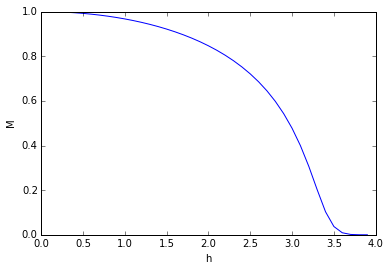

In [9]:
%pylab inline
plot([2*x for x in hlist],Mlist)
xlabel('h')
ylabel('M')
ylim([0,1])